In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import json
import time
from shapely.geometry import box,LineString,Point,MultiPoint,MultiLineString,MultiPolygon,Polygon
from shapely.ops import unary_union
import socket
from collections import defaultdict
from numba import prange
import gc
current_dir = os.path.join(os.getcwd()) 
mother_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print('mother_path:', mother_path)
sys.path.append(os.path.join(mother_path, 'PreProcessing'))
sys.path.append(os.path.join(mother_path))
from FittingProcedures import *
from plot import *
from Potential import *
from Grid import *
from PreprocessingObj import *
from ODfromfma import *
import time
from GeometrySphere import *
from Polycentrism import *
from PolycentrismPlot import *
from ModifyPotential import *
from MainPolycentrism import *
from GenerateModifiedFluxesSimulation import *

#import rustworkx as rw
import ast
## BASIC PARAMS
gc.set_threshold(10000,50,50)
plt.rcParams.update({
    "text.usetex": False,
})

if socket.gethostname()=='artemis.ist.berkeley.edu':
    TRAFFIC_DIR = '/home/alberto/LPSim/traffic_phase_transition'
else:
    TRAFFIC_DIR = os.getenv('TRAFFIC_DIR')
name = 'BOS'
grid_size = 0.02
hexagon_resolution = 8
dir_grid = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))

## BASIC NEEDED OBJECTS
SFO_obj = GeometricalSettingsSpatialPartition(name,TRAFFIC_DIR)
bbox = SFO_obj.bounding_box
minx, miny, maxx, maxy = bbox
dir_geometries = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(name))
grid = GetGrid(grid_size,SFO_obj.bounding_box,'EPSG:4326',dir_geometries)
grid = GetBoundariesInterior(grid,SFO_obj.gdf_polyons,name)
df_distance,FoundDistMat = GetDirectionMatrix(dir_geometries,grid_size)
Tij = GetODGrid(dir_geometries,str(grid_size))
lattice = nx.read_graphml(os.path.join(dir_grid,"centroid_lattice.graphml"))
#VectorField = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/VectorField.csv')
#Potential = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/PotentialDataFrame.csv')

# GET POTENTIAL AND VECTOR FIELD
VectorField = GetVectorField(Tij,df_distance)
VectorFieldDir = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))
lattice = GetPotentialLattice(lattice,VectorField)
lattice = SmoothPotential(lattice)
PotentialDataframe = ConvertLattice2PotentialDataframe(lattice)
PotentialDataframe = CompletePotentialDataFrame(VectorField,grid,PotentialDataframe)
SumPot = np.sum(PotentialDataframe['V_out']) 
NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]




mother_path: /home/alberto/LPSim/traffic_phase_transition/scripts
PyMC3 not installed
Initialize Grid: 0.02
ALREADY COMPUTED
Get Boundaries: 
Boundary Type:  <class 'shapely.geometry.multipolygon.MultiPolygon'>
Grid Head:     i  j  centroidx  centroidy      area  index  population  with_roads  \
0  0  0 -71.718385  41.772821  1.564818      0         0.0       False   
1  0  1 -71.718385  41.792821  1.564818      1         0.0       False   
2  0  2 -71.718385  41.812821  1.564818      2         0.0       False   
3  0  3 -71.718385  41.832821  1.564818      3         0.0       False   
4  0  4 -71.718385  41.852821  1.564818      4         0.0       False   

                                            geometry position relation_to_line  
0  POLYGON ((-71.70839 41.78282, -71.70839 41.762...  outside         not_edge  
1  POLYGON ((-71.70839 41.80282, -71.70839 41.782...  outside         not_edge  
2  POLYGON ((-71.70839 41.82282, -71.70839 41.802...  outside         not_edge  
3  POLYG

# COMPUTE PI

##### COMPUTE POLYCENTRISM

In [2]:
PI,LC,UCI,result_indices,_,cumulative,Fstar = ComputeUCI(grid,PotentialDataframe,df_distance)
print("PI: ",PI,"LC: ",LC,"UCI: ",UCI)


Number of Squares that form the edge:  621
Number of Distances Among edges:  385641
Control that the number of distances is equal to the Number of `grid units` in the edge squared:  385641
Vmax:  36.16513409399272 V:  28.633406065121406
PI:  0.20825936962645986
*********** LORENZ CURVE ************
cumulative:  [-7.45986123e-04 -1.42014536e-03 -2.05875106e-03 ...  9.93346275e-01
  9.96617960e-01  1.00000000e+00]
Fstar:  3182
index:  11063814
*************************************
*********** COMPUTE UCI ************
Sum Potential:  709214296.0473678
Number of Edges boundary:  621
LC:  0.915156744319816 PI:  0.20825936962645986 UCI:  0.19058996668144818
*********** END UCI ************
PI:  0.20825936962645986 LC:  0.915156744319816 UCI:  0.19058996668144818


(<matplotlib.lines.Line2D at 0x7f6365f98a10>,
 <matplotlib.lines.Line2D at 0x7f6365f98d40>)

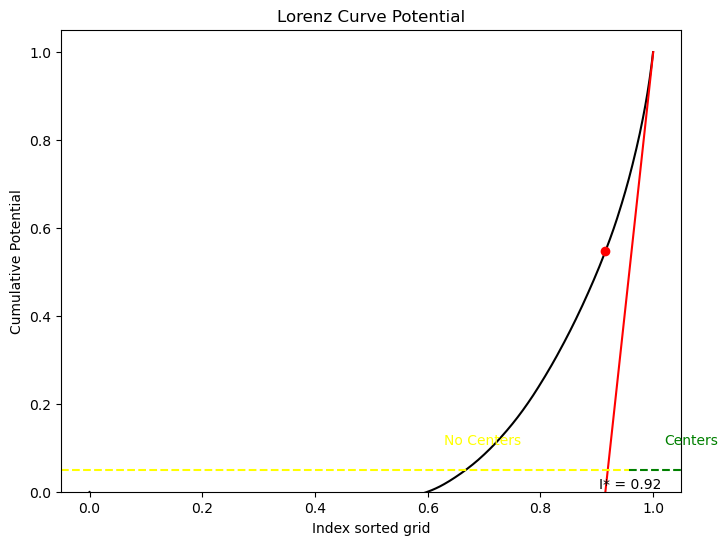

In [3]:
PlotLorenzCurve(cumulative,Fstar,result_indices,dir_grid)

# GENERATE NEW CONFIGURATIONS

In [2]:
import os
TRAFFIC_DIR = '/home/alberto/LPSim/traffic_phase_transition'
with open(os.path.join(TRAFFIC_DIR,'data','carto',name,'grid','0.02','origindest2grid.json'),'r') as f:
    OD2grid = json.load(f)

with open(os.path.join(TRAFFIC_DIR,'data','carto',name,'grid','0.02','grid2origindest.json'),'r') as f:
    grid2OD = json.load(f)
with open(os.path.join(TRAFFIC_DIR,'data','carto',name,'osmid2idx.json'),'r') as f:
    osmid2index = json.load(f)

list_peaks = [2,3,4,5,6,8,10,100,200,500] # [2,3,4,5,6,8,10,
InfoConfigurationPolicentricity = {num_peaks: defaultdict() for num_peaks in list_peaks}
Covarinaces = [1,2,4,8,10,15,20,30,50,100]
for cv in Covarinaces:
    for distribution in ['exponential']:#['gaussian','exponential']:#,'exponential']: # NOTE: There is some problem with the exponential distribution
        InfoCenters = {'center_settings': {"type":distribution},'covariance_settings':{"covariances":{"cvx":cv,"cvy":cv},"Isotropic": True,"Random": False}}
        #parameter_values = ((InfoConfigurationPolicentricity,grid,SFO_obj,Tij,df_distance,num_peaks) for num_peaks in list_peaks)
        for num_peaks in list_peaks:
            InfoConfigurationPolicentricity,UCI = ModifyMorphologyCity(InfoConfigurationPolicentricity,grid,SFO_obj,Tij,df_distance,lattice,num_peaks,TRAFFIC_DIR,name,grid_size,InfoCenters,fraction_fluxes = 200,verbose = True)
            if socket.gethostname()=='artemis.ist.berkeley.edu':
                SaveOd = "/home/alberto/LPSim/LivingCity/berkeley_2018/new_full_network"
            else:
                SaveOd = f'/home/aamad/Desktop/phd/traffic_phase_transition/data/carto/{name}/OD'
            df1 = ConcatenateODsInputSimulation(SFO_obj,grid_size,NameCity)
            GetODForSimulation(InfoConfigurationPolicentricity[num_peaks]['Tij'],
                               CityName2RminRmax,
                               name,
                               osmid2index,
                               grid2OD,
                               1,
                               SaveOd,
                               7,
                               8,
                               round(UCI,3),
                               df1)
            
#with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 4) as pool:
    # Map the function to the parameter values
#    pool.map(ModifyMorphologyCity, parameter_values)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Modify Morphology 2
Center Settings: 
Type:  exponential
Covariance: (1,1
******************
Number of grids with people:  2157
Number of couples of grids with flux:  133569
Total Population:  4546481.94410453
Total Flux:  735486
Fraction of grids populated:  0.6203623813632442
Fraction of couples of grids with fluxes:  0.011048321237328601
******************
Plotting fluxes coming from raw data


PIPELINE MODIFICATION FLUXES starting...
++++++++++++ Generate Index Centers ++++++++++++
Number of Populated Grids:  1489
Average distance from Center:  28.965270752306463
+++++++++ Setting Covariances ++++++++
Isotropic and Not Random
Multiplicator:  0.028108229328994302
Number of people in grid with flux >  1 :  19001
Number of couples of grids with flux >  1 :  19001
Fraction of couples of grids with flux >  1 :  0.0015716906754597304
Number of people in grid with flux >  5 :  11881
Number of couples of grids with flux >  5 :  11881
Fraction of couples of grids with flux >  5 :  0.0009827512717823829
Number of people in grid with flux >  10 :  8285
Number of couples of grids with flux >  10 :  8285
Fraction of couples of grids with flux >  10 :  0.0006853037864419698
Number of people in grid with flux >  20 :  6457
Number of couples of grids with flux >  20 :  6457
Fraction of couples of grids with flux >  20 :  0.0005340985575203137
Number of people in grid with flux >  30 :  4929

/home/alberto/LPSim/traffic_phase_transition/scripts/GeometrySphere/PolycentrismPlot.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(10, 10))


3125
index Fstar:  3125
cumulative:  [-5.72138913e-04 -1.10640223e-03 -1.63569082e-03 ...  9.94332410e-01
  9.97165499e-01  1.00000000e+00]
x:  [0.00000000e+00 2.87604257e-04 5.75208513e-04 ... 9.99137187e-01
 9.99424791e-01 9.99712396e-01]
x[idxFstar]:  0.8987633016968651
Generation Fluxes UCI:  0.256
COMPUTING /home/alberto/LPSim/LivingCity/berkeley_2018/new_full_network/BOS_oddemand_7_8_R_150_UCI_0.256.csv
number of couples of origin-destination:  12089529
NoneInOrigins:  0  NoneInDestinations:  0  NoneInOD:  0
total_number_people_considered:  525204
total_number_people_not_considered:  0
ratio:  1.0
df1:
    SAMPN  PERNO  origin_osmid  destination_osmid      dep_time  origin  \
0      0      0      66293190           66293190  25200.000000   18704   
1      1      1      66293190           66293190  25214.790779   18704   
2      2      2      66293190           66293190  25229.581558   18704   
3      3      3      66293190           66293190  25244.372336   18704   
4      4     

#### This snippet Launches the creation of new morphology for BOS in parallel in the number of centers and covariances.

# CREATION OD FILES

In [ ]:
'''
{'logk': 0.0003055803472447064, 'alpha': 0.0002546775749831938, 'gamma': -0.07627729954795813, '1/d0': 4.8774299414384545}
Number centers considered:  2
[ 3.37484752 51.76501691]
bin index:  2
Length filtered grid:  32  rv:  3.3748475174250743
bin index:  23
Length filtered grid:  60  rv:  51.76501690675754
New population:  574776957.9199114
k:  1.0003056270416752  alpha:  0.0002546775749831938  beta:  -0.07627729954795813  d0:  4.8774299414384545
<k*p>:  165358.83
<p**alpha>:  1.0017573
<p**beta>:  0.6491281
<exp(-d/d0)>:  0.010571069

'''


with open('/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/potential/FitVespignani.json','r')as f:
    fitGLM = json.load(f)
print(fitGLM)
k = np.exp(fitGLM['logk'])
alpha =fitGLM['alpha']
beta = fitGLM['gamma']
d0 = fitGLM['1/d0']
list_peaks = [2,3,4,5,6,8,10]
InfoConfigurationPolicentricity = {num_peaks: defaultdict() for num_peaks in list_peaks}
total_population = np.sum(grid['population'])
total_flux = np.sum(Tij['number_people'])

population,centroidx,centroidy,index,filtered_grid = FilterPopulation(grid)
coords_center,_ = ExtractCenterByPopulation(grid)

#CenterMass = ComputeCM(grid,coords_center)

grid['is_populated'] = grid['population']>0
grid['coords'] = grid.apply(lambda x: ProjCoordsTangentSpace(x['centroidx'],x['centroidy'],coords_center[0],coords_center[1]),axis = 1)
grid['distance_from_center'] = grid.apply(lambda x: polar_coordinates(np.array([x['centroidx'],x['centroidy']]),np.array(x['coords']))[0],axis = 1)
PrintInfoFluxPop(grid,Tij)
for num_peaks in list_peaks:
    InfoConfigurationPolicentricity[num_peaks]['grid'] = grid.copy()
    InfoConfigurationPolicentricity[num_peaks]['Tij'] = Tij.copy()
for num_peaks in list_peaks:
    print('Number centers considered: ',num_peaks)
    index_centers = GenerateIndexCenters(grid,num_peaks)
    PlotPositionCenters(grid,SFO_obj,index_centers)
    covariances = SetCovariances(index_centers)
    new_population = ComputeNewPopulation(grid,index_centers,covariances,total_population)
    # Store Data About Population and Fluxes
    
    Factor = np.sum(grid['population'])/np.sum(new_population)
    new_population = new_population*Factor
    InfoConfigurationPolicentricity[num_peaks]['grid']['population'] = new_population
    InfoConfigurationPolicentricity[num_peaks]['grid'].plot(column = 'population')
    plt.show()
#    IPF = ipfn.ipfn(np.array([new_population]), np.array([[int(total_population)]]), np.array([[0]]),convergence_rate=0.01, max_iteration=1000, verbose=True)
#    new_population_ipfn = IPF.iteration()
#    InfoConfigurationPolicentricity[num_peaks]['grid']['new_population'] = new_population_ipfn[0][0]
    t0 = time.time() 
    Modified_Fluxes =  GravitationalModel(InfoConfigurationPolicentricity[num_peaks]['grid']['population'].to_numpy(dtype = np.float32),df_distance['distance'].to_numpy(dtype = np.float32),k,alpha,beta,d0)
    Multiplicator = total_flux/Modified_Fluxes.sum()
    Modified_Fluxes = Modified_Fluxes*Multiplicator
    t1 = time.time()
    print('Time to compute the model: ',t1 - t0)
    t0 = time.time()
#    IPF = ipfn.ipfn(np.array([Modified_Fluxes]), np.array([[total_flux]]), np.array([[0]]),convergence_rate=0.01, max_iteration=1000, verbose=True)
#    Modified_Fluxes_ipfn = IPF.iteration()
    InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'] = Modified_Fluxes    #Modified_Fluxes_ipfn[0][0]    
    print('Afeter Population Generation and Gravity:')
    PrintInfoFluxPop(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['Tij'])
    print("----------------------------------")
    n,bins = np.histogram(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'].loc[InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people']>0],bins = 100)
    n1,bins1 = np.histogram(Tij['number_people'].loc[Tij['number_people']>0],bins = 100)
    plt.scatter(bins[:-1],n)
    plt.scatter(bins1[:-1],n1)
    plt.yscale('log')
    plt.legend(['Fitted','Original'])
    plt.title('DIstribution fluxes fitted')
    plt.show()
    plt.hist(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'],bins = 20)
    plt.title('DIstribution fluxes fitted')
    plt.show()
    t1 = time.time()
    print('Time to compute the ipfn: ',t1 - t0)    
    t0 = time.time()
    InfoConfigurationPolicentricity[num_peaks]['vector_field'] = GetVectorField(InfoConfigurationPolicentricity[num_peaks]['Tij'],df_distance)
    t1 = time.time()
    print('Time to compute the vector field: ',t1 - t0)
    lattice = GetPotentialLattice(lattice,InfoConfigurationPolicentricity[num_peaks]['vector_field'])
    lattice = SmoothPotential(lattice)
    InfoConfigurationPolicentricity[num_peaks]['potential'] = ConvertLattice2PotentialDataframe(lattice)
    InfoConfigurationPolicentricity[num_peaks]['potential'] = CompletePotentialDataFrame(VectorField,InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'])
    print('*********** COMPUTE UCI ************')
    SumPot = InfoConfigurationPolicentricity[num_peaks]['potential']['V_out'].sum()
    NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]
    PI = LaunchComputationPI(df_distance,InfoConfigurationPolicentricity[num_peaks]['grid'],SumPot,NumGridEdge,InfoConfigurationPolicentricity[num_peaks]['potential'])
    result_indices,angle,cumulative,Fstar = LorenzCenters(InfoConfigurationPolicentricity[num_peaks]['potential']['V_out'].to_numpy())
    InfoConfigurationPolicentricity[num_peaks]['PI'] = PI
    LC = Fstar/len(cumulative)
    InfoConfigurationPolicentricity[num_peaks]['LC'] = LC
    UCI = PI*LC
    InfoConfigurationPolicentricity[num_peaks]['UCI'] = UCI
    print('Sum Potential: ',SumPot)
    print('Number of Edges boundary: ',NumGridEdge)
    print('LC: ',LC,'PI: ',PI,'UCI: ',UCI)
    print('************PLOTTING************')
    dir_grid = os.path.join(TRAFFIC_DIR,'data','carto',name,'OD')
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    dir_grid = os.path.join(dir_grid,str(grid_size))
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    dir_grid = os.path.join(dir_grid,str(num_peaks))
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    dir_grid = os.path.join(dir_grid,'UCI_{}'.format(round(UCI,3)))
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    PlotVFPotMass(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],InfoConfigurationPolicentricity[num_peaks]['vector_field'],dir_grid,label_potential = 'population',label_fluxes = 'Ti')
    PotentialContour(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],SFO_obj,dir_grid)
    PotentialSurface(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
    PlotRotorDistribution(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
    fig,ax = plt.subplots(1,1,figsize = (10,10))
    PlotLorenzCurve(ax,cumulative,Fstar,result_indices,shift = 0.1)

    

In [ ]:
PlotVFPotMass(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],InfoConfigurationPolicentricity[num_peaks]['vector_field'],dir_grid,label_potential = 'population',label_fluxes = 'Ti')
PotentialContour(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],SFO_obj,dir_grid)
PotentialSurface(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
PlotRotorDistribution(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
fig,ax = plt.subplots(1,1,figsize = (10,10))
PlotLorenzCurve(ax,cumulative,Fstar,result_indices,shift = 0.1)
